In [99]:
import copy
# ------------------------------
import pandas as pd
import numpy as np
# ------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Описание выбранного набора данных и решаемая задача

Тема курсовой работы **"Байесовская оптимизация для настройки гипперапараметров моделей машинного обучения"**

Задача: применение на практике байесовской оптимизации для настройки гипперпараметров моделей машиннного обучения.

Перед выполнением поставленной задачи курсовой работы необходимо определить решаему задачу в области машщинного обучения и данные её характеризующие, выбрать модель в равной степени хорошо подходящую для решения обеих задач.

В качетсве решаемой задачи машинного обучения выбрана задача кредитного скорринга, то есть классификация клиента как "одобрить кредит" или "не одобрить кредит" по некторому набору признаков. Набор данных взять с сайта [kaggle](https://www.kaggle.com/competitions/GiveMeSomeCredit/overview), ниже приведено подробное описание набора данных.

Набор данных представляет собой набор файлов в формате csv разбитый на обучающую (cs-training) и тестовые (cs-test) выборки. Обучающая выборка содержит 150.000 объектов, тестовая - 102.000 объектов. Все объекты описываются 11 признаками:
- **SeriousDlqin2yrs** - Лицо имело просроченную задолженность на 90 дней или более;
- **RevolvingUtilizationOfUnsecuredLines** - Общий остаток по кредитным картам и личным кредитным линиям, за исключением недвижимости и отсутствия задолженности по рассрочке;
- **age** - Возраст заемщика в годах;
- **NumberOfTime30**-59DaysPastDueNotWorse - Количество раз, когда заемщик просрочил платеж на 30–59 дней, но не больше, за последние 2 года;
- **DebtRatio** - Ежемесячные выплаты по долгам, алименты, расходы на проживание, деленные на ежемесячный валовой доход;
- **MonthlyIncome** - Ежемесячный доход;
- **NumberOfOpenCreditLinesAndLoans** - Количество открытых кредитов (кредиты с рассрочкой платежа, например, автокредит или ипотека) и кредитных линий (например, кредитные карты);
- **NumberOfTimes90DaysLate** - Количество просрочек заемщика на 90 дней и более;
- **NumberRealEstateLoansOrLines** - Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья;
- **NumberOfTime60-89DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 60–89 дней, но не больше за последние 2 года;
- **NumberOfDependents** - Количество иждивенцев в семье, не считая их самих (супруг(а), дети и т. д.).

Каждый из них является численным, поэтому  вдальнейшем не появится необходимости конструирования корректного численного представления категориальных данных.

В данной работе для оптимизации выбрана модель дерева решений по ряду причин:
- Легкость настройки - ряд ключевых гипперпараметров модели представляют собой целочисленные значения, что значительно облегчит применение байесовской оптимизации;
- Хороший baseline - построенная и оптимизированная модель послужит хорошей основой для дальнейшей работы и улучшения результатов;

# Предварительный анализ и очистка данных

## Информация о наборе данных

In [100]:
data = pd.read_csv("data/cs-training.csv", index_col=0)
display(data.head()), display(data.info()), display(data.describe().T)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

None

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


(None, None, None)

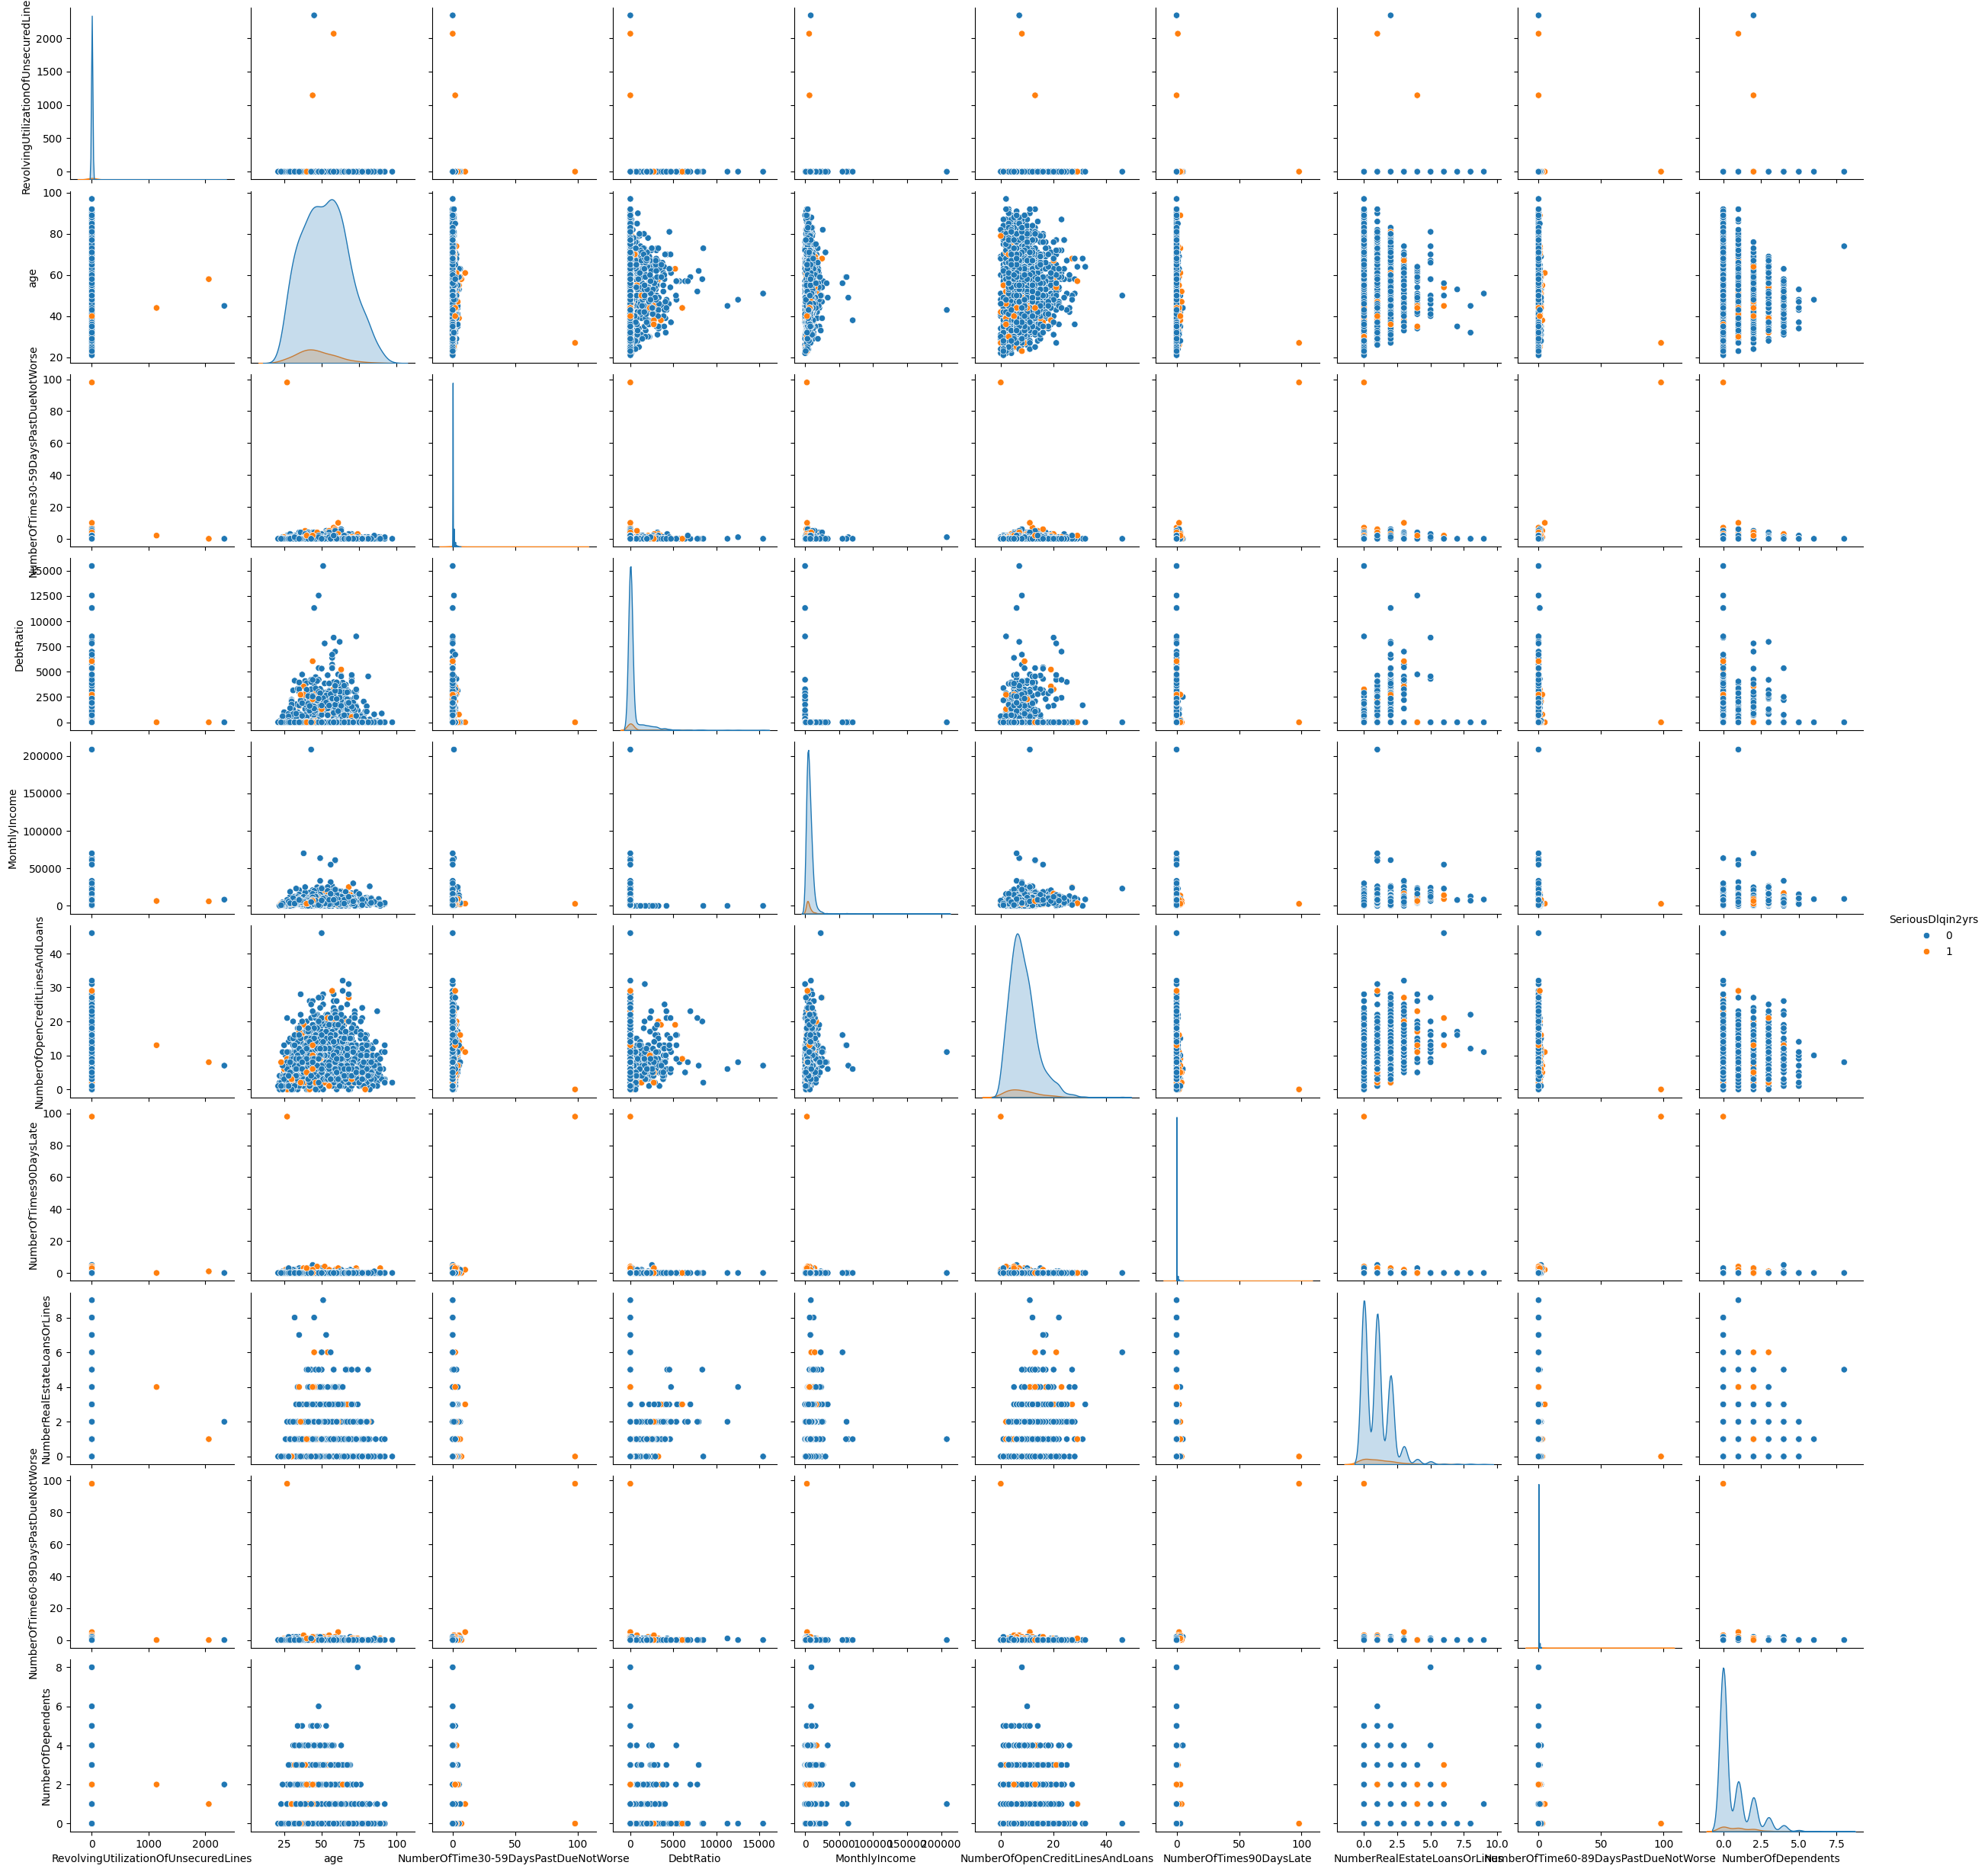

In [101]:
sns.pairplot(data.iloc[0:2000,:], hue= 'SeriousDlqin2yrs')

In [102]:
print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

## Описательный анализ данных 

### Удаление пропусков в наборе данных

Как видно выше, пропуски имеются в признаках MonthlyIncome и NumberOfDependents. Объекты с пропусками не удаляются, так как будет потеряна не малая часть обучающей выборки, но пропуски будут заменены медианными значениями (или интерполированием). 

In [103]:
nan_index_MonthlyIncome = data[data["MonthlyIncome"].isna() == True].index
nan_index_NumberOfDependents = data[data["NumberOfDependents"].isna() == True].index
# median_MonthlyIncome = data["MonthlyIncome"].median()
# data.loc[nan_index_MonthlyIncome, "MonthlyIncome"] = median_MonthlyIncome
data["MonthlyIncome"] = data["MonthlyIncome"].interpolate()
# median_NumberOfDependents = data["NumberOfDependents"].median()
# data.loc[nan_index_NumberOfDependents, "NumberOfDependents"] = median_NumberOfDependents
data["NumberOfDependents"] = data["NumberOfDependents"].interpolate()

print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### Поиск и удаление выбросов

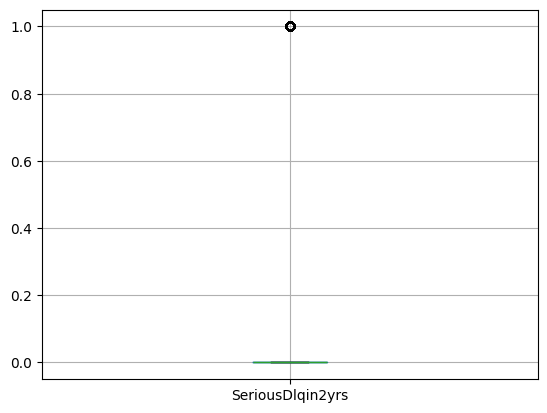

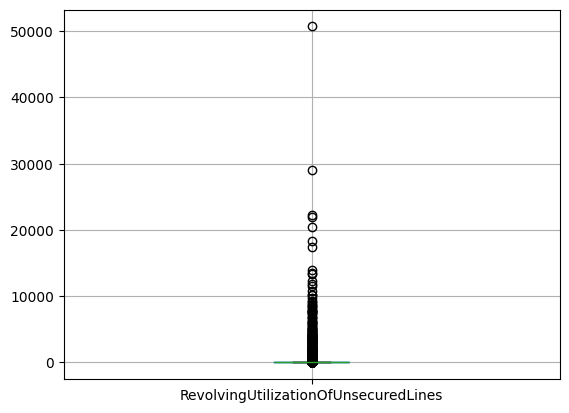

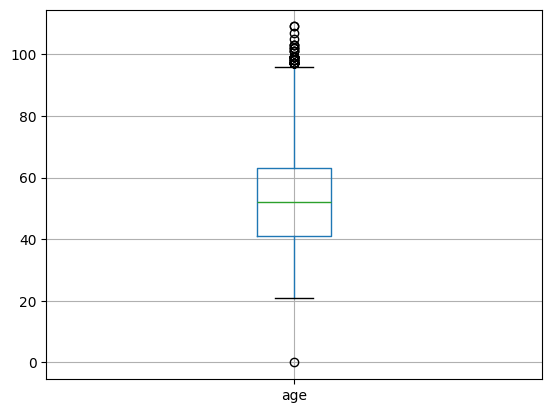

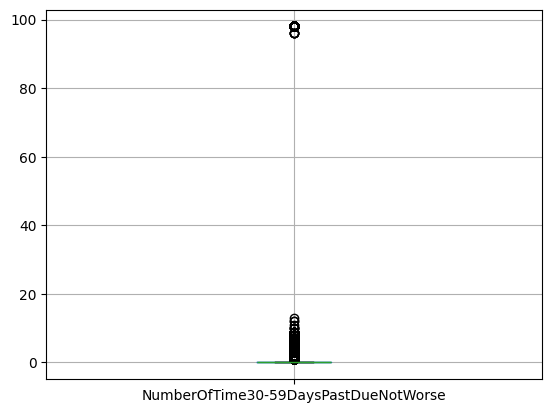

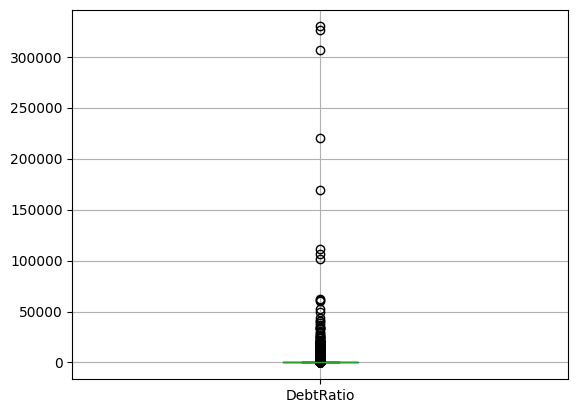

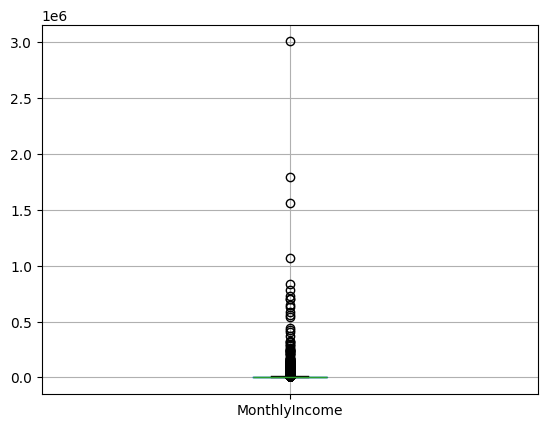

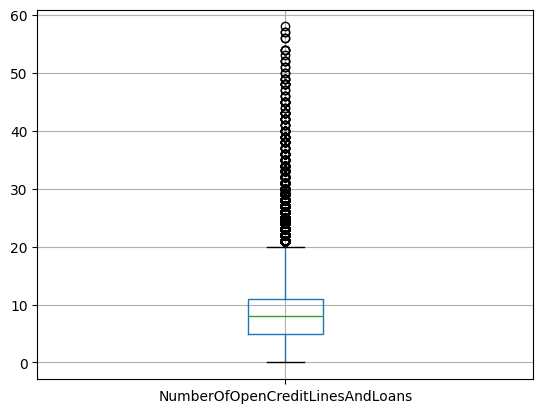

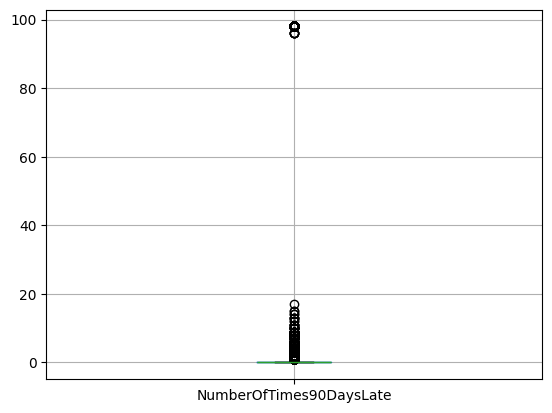

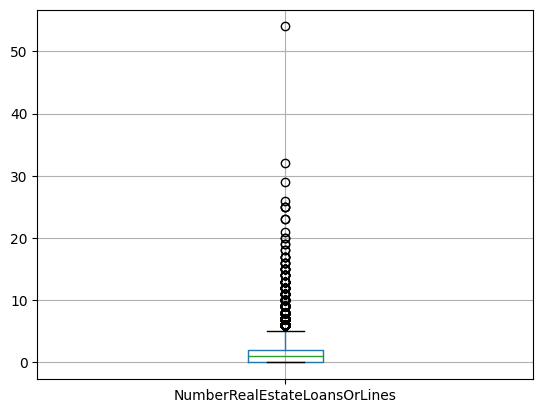

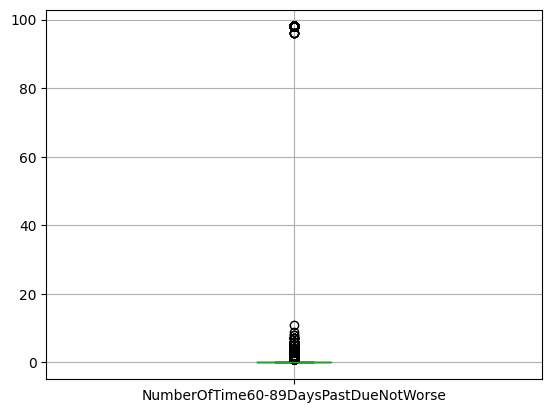

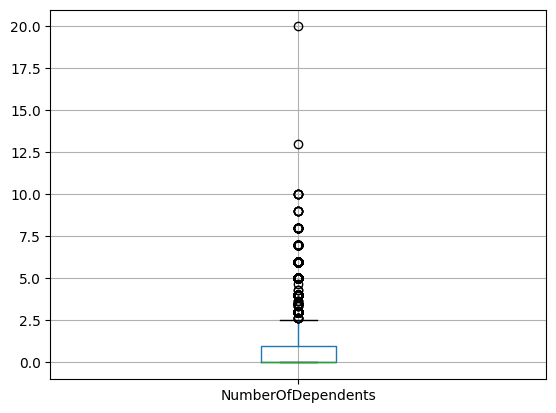

In [104]:
for col in data.columns:
    plt.subplots(1, 1)
    pd.DataFrame(data[col]).boxplot()
    plt.show()

Сначала будут удалены те объекты чьё значение "age" превыщает полтора квартильного размаха или которое меньше 18 лет. Нижняя допустимая граница возраста выбрана из предположения, что, в среднем, человек начинает зарабатывать деньги и, следоватльно, имеет возможность взять кредит, с 18 лет.

Другие, пока что, заменяю на медиану. Кроме NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, так как, в основном, они равны нулю и выбросы в этих признаках несут важную инфорацию. 

In [105]:
topline = data["age"].quantile(0.75) + (data["age"].quantile(0.75) - data["age"].quantile(0.25)) * 1.5 
downline = 18
data = data.drop(data["age"][data["age"] > topline].index)
data = data.drop(data["age"][data["age"] < downline].index)

In [106]:
another_columns = set(data.columns) - set(["age", "SeriousDlqin2yrs", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"])
for column in another_columns:
    Q1, Q3 = data[column].quantile(0.25), data[column].quantile(0.75)
    IRQ = Q3 - Q1 
    topline = Q3 + IRQ * 1.5 
    downline = Q1 - IRQ * 1.5 
    median = data[column].interpolate()
    data.loc[data[data[column] > topline].index, column] = median
    data.loc[data[data[column] < downline].index, column] = median

Теперь построим гистограмму распределения данных и обратим внимание на дизбаланс классов в таргете, а именнно на графике "SeriousDlqin2yrs".

In [107]:
# import seaborn as sns

# for column in data.columns:
#     display(sns.displot(data[column]))

## Построим корреляционную матрицу

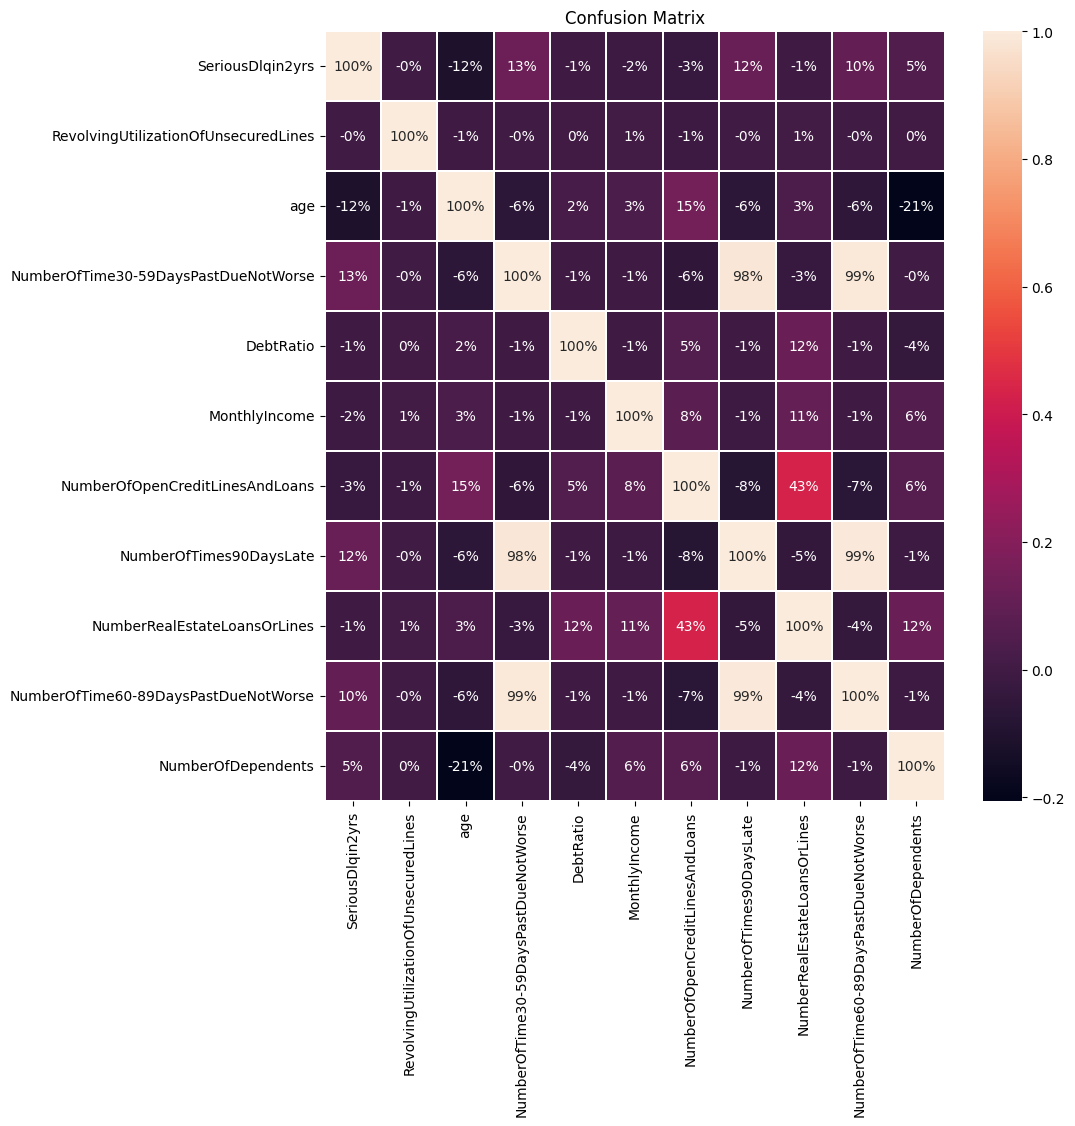

In [108]:
def draw_cov(data):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title('Confusion Matrix')
    sns.heatmap(data.corr(), annot=True, fmt="0.0%", linewidth=0.1)

draw_cov(data)

# Выявим наиболее информативные атрибуты

Эта часть анализа выполнена с помощью случайного леса - обученный на всей выборке, модель покажет информативность и вариативность каждого отдельного атрибута. 

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X, y = data[data.columns[1:]], data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

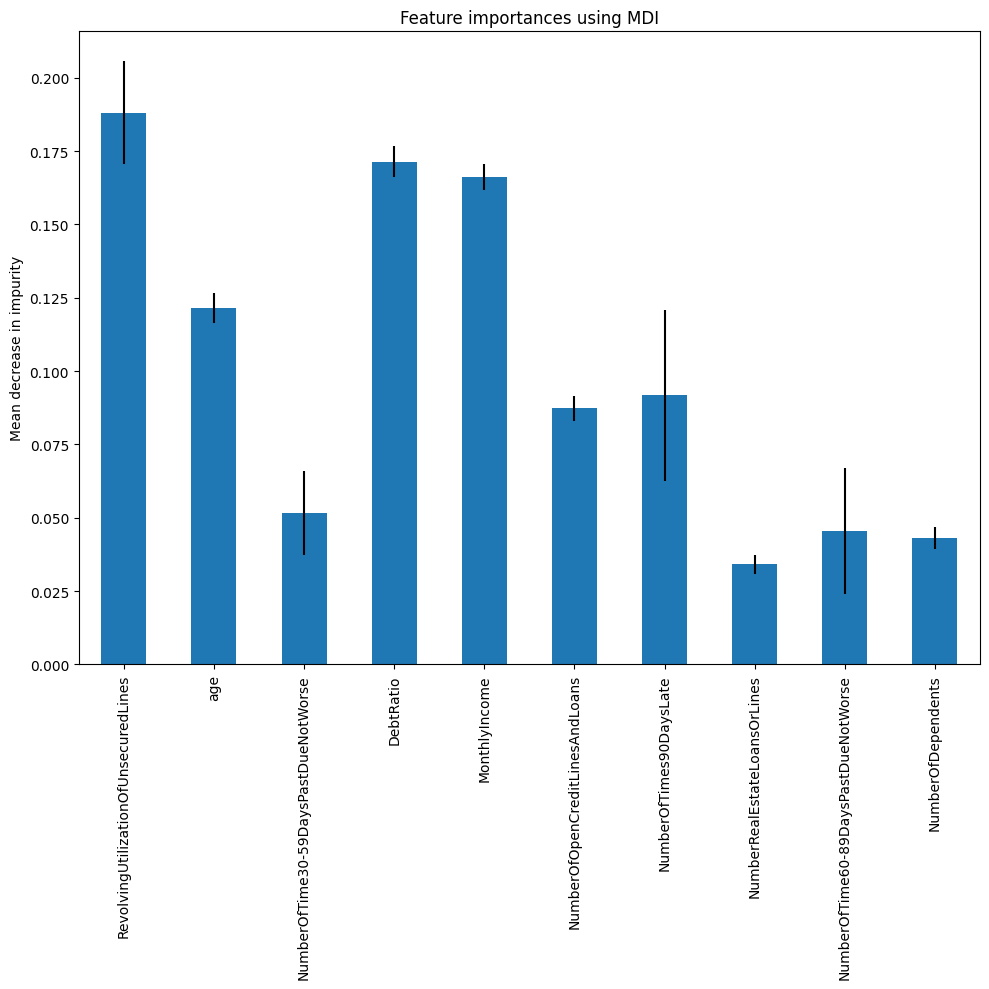

In [111]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks(np.arange(0, 10, 1), labels=X.columns.tolist())
fig.tight_layout()

## Продолжение анализа важности атрибутов

Анализ атрибутов с помощью случайного леса ничего существенного не дал, поэтому решено применить PCA (метод главных компонент).

Как видно, 6 первых атрибутов PCA объясняют ~90% всей дисперсии данных! 

In [112]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

pca_machine = PCA(n_components=min(X.shape[0], X.shape[1]), svd_solver="covariance_eigh")

pca_X = pca_machine.fit(pd.DataFrame(scaled_X, columns=X.columns.values))

In [113]:
most_explainde_pca_X = pca_X.explained_variance_ratio_[:6]
most_explainde_pca_X, most_explainde_pca_X.sum()

(array([0.29949069, 0.15293915, 0.1223798 , 0.10112232, 0.10014175,
        0.09361935]),
 0.8696930563372003)

In [114]:
transformed_X = pca_machine.transform(pd.DataFrame(scaled_X, columns=X.columns.values))

# Подбор моделей

In [141]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

X, y = transformed_X, data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  

## DecisionTreeClassifier

In [116]:
from sklearn.tree import DecisionTreeClassifier

pipline = make_pipeline(StandardScaler(), DecisionTreeClassifier())
model_DT = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_DT.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_DT, X, y))}")

 Accuracy: 0.8937288271226226
 Cross validation score: 0.8953412505912492


## GaussianNB

In [117]:
from sklearn.naive_bayes import GaussianNB

pipline = make_pipeline(GaussianNB())
model_GNB = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_GNB.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_GNB, X, y))}")

 Accuracy: 0.916695564032116
 Cross validation score: 0.9169878670614633


## LogisticRegression

Второй кандидат

In [118]:
from sklearn.linear_model import LogisticRegression 

pipline = make_pipeline(LogisticRegression())
model_LogReg = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_LogReg.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_LogReg, X, y))}")

 Accuracy: 0.934514124143082
 Cross validation score: 0.9338397090984583


## Random Forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

pipline = make_pipeline(RandomForestClassifier())
model_RF = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_RF.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_RF, X, y))}")

 Accuracy: 0.9330470271279575
 Cross validation score: 0.9322392220611609


## Gradient Boosting

In [120]:
from sklearn.ensemble import GradientBoostingClassifier

pipline = make_pipeline(GradientBoostingClassifier(criterion="squared_error", max_depth=7, min_samples_leaf=9, min_samples_split=10, n_estimators=10))
model_GB = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_GB.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_GB, X, y))}")

 Accuracy: 0.9346208221078183
 Cross validation score: 0.9342264966919218


## KNN

In [121]:
from sklearn.neighbors import KNeighborsClassifier

pipline = make_pipeline(KNeighborsClassifier())
model_KNN = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_KNN.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_KNN, X, y))}")

 Accuracy: 0.9333937955133506
 Cross validation score: 0.9324192711853792


## Neural Network

Пока наиболее перспективная модель

In [ ]:
from sklearn.neural_network import MLPClassifier

# Сюда вставлем параметры лучшей модели
params = {'n_layers': 16, 'n_neurons_layer_0': 17, 'n_neurons_layer_1': 36, 'n_neurons_layer_2': 100, 'n_neurons_layer_3': 98, 'n_neurons_layer_4': 4, 'n_neurons_layer_5': 46, 'n_neurons_layer_6': 43, 'n_neurons_layer_7': 100, 'n_neurons_layer_8': 97, 'n_neurons_layer_9': 80, 'n_neurons_layer_10': 45, 'n_neurons_layer_11': 60, 'n_neurons_layer_12': 27, 'n_neurons_layer_13': 83, 'n_neurons_layer_14': 34, 'n_neurons_layer_15': 29, 'activation': 'identity', 'solver': 'adam', 'alpha': 1.2749784046091487e-06, 'learning_rate': 'constant', 'learning_rate_init': 0.0023467925879180583, 'max_iter': 481, 'tol': 8.591334198594918e-05, 'momentum': 0.41654341899964975}

# Выбираем только ключи вида 'n_neurons_layer_*' и сортируем их по номеру слоя
neurons = [v for k, v in params.items() if k.startswith('n_neurons_layer_')]
neurons_sorted = sorted(neurons)  # Сортировка по номеру слоя
hidden_layer_sizes = tuple(neurons_sorted)

# Ключи, которые не нужны в финальном словаре для MLPClassifier
keys_to_remove = ['n_layers'] + [f'n_neurons_layer_{i}' for i in range(len(neurons))]
final_params = {k: v for k, v in params.items() if k not in keys_to_remove}

# Добавляем hidden_layer_sizes
final_params['hidden_layer_sizes'] = hidden_layer_sizes

# Пайплайн остаётся постольку поскольку
pipline = make_pipeline(MLPClassifier(**final_params))
model_MLP = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_MLP.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_MLP, X, y))}")

 Accuracy: 0.9342740537224252
 Cross validation score: 0.9400000000000001


## AdaBoosting

In [123]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipline = make_pipeline(AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion="gini", max_depth=7, min_samples_leaf=9, min_samples_split=10), n_estimators=2))
model_Ada = pipline.fit(X_train, y_train)
print(f" Accuracy: {model_Ada.score(X_test, y_test)}\n Cross validation score: {np.mean(cross_val_score(model_Ada, X, y))}")

c:\Users\yurak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\yurak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\yurak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\yurak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is 

 Accuracy: 0.934514124143082
 Cross validation score: 0.9343998864881206


## Подбор гиперпараметров

Оптимизация готова, нужно применить для демонстрации работоспособности.

А для kaggle настройка с помощью optuna - умная версия random search. Оцениваю по roc_auc, так как хочу получть 

## Настрйока гиперпараметров MLPClassifier

In [150]:
# import optuna
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_iris  # или любой ваш датасет
# from sklearn.model_selection import StratifiedKFold

# # Определение целевой функции для optuna
# def objective(trial):
#     n_layers = trial.suggest_int('n_layers', 1, 10) # Задаем глубину сети
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_neurons_layer_{i}', 1, 200)) # Задаем количество нейронов в сети
#     params = {
#         'hidden_layer_sizes': tuple(layers),
#         'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
#         'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
#         'alpha': trial.suggest_float('alpha', 1e-10, 1, log=True),  # log-шкала для малых значений
#         'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
#         'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 1, log=True),
#         'max_iter': trial.suggest_int('max_iter', 200, 1000),
#         'tol': trial.suggest_float('tol', 1e-10, 1, log=True),
#         'momentum': trial.suggest_float('momentum', 0.001, 1),
#         'random_state': 42,
#         'early_stopping': True,  # Рекомендуется для оптимизации
#         'n_iter_no_change': 50,  # Ранняя остановка, если нет улучшений
#     }

#     # Для 'sgd' и 'adam' можно добавить momentum
#     if params['solver'] in ['sgd', 'adam']:
#         params['momentum'] = trial.suggest_float('momentum', 0.001, 1)

#     model = MLPClassifier(**params)

#     # Кросс-валидация для оценки качества
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     score = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()

#     return score

# # Создание study и запуск оптимизации
# study = optuna.create_study(direction='maximize')  # Максимизируем roc_auc
# study.optimize(objective, n_trials=100)  # Количество испытаний

# # Вывод результатов
# print("Лучшие параметры:", study.best_params)
# print("Лучшее значение roc_auc:", study.best_value)

## Настрйока гиперпараметров Logistic Regression

In [ ]:
### Пока не стоит ###

## Kaggle
Так как данные взяты с соревнования kaggle, то я пользуюсь возможностью проверки моделей на абсолютно новых для них данных и оценкой которой даёт система проверки kaggle:
1. **Decision Tree** - 0.498
2. **AdaBoosting** - 0.4045
3. **GaussianNB** - 0.496
4. **Logistic Regression** - 0.592
5. **Random Forest** - 0.473
6. **Gradient Boosting** - 0.497
7. **KNN** - 0.518
8. **Neural Network** - 0.606

In [140]:
# Функция для отправки результатов работы модели на Kaggle
def try_kaggle(model, X):
    probs = model.predict_proba(X)
    ans = []
    for prob in probs:
        ans.append(np.max(prob))

    out_pd = pd.DataFrame({
        "Id": [i for i in range(1, len(ans) + 1)],
        "Probability": ans
    })
    out_pd.to_csv("out.csv", index=False)

In [ ]:
data_test = pd.read_csv("data/cs-test.csv", delimiter=',', index_col=0)
X_test_test = data_test[data_test.columns[1:]].interpolate()
scaled_X_test_test = scaler.fit_transform(X_test_test)
try_kaggle(model_MLP, scaled_X_test_test)